#Mount drive, import some utils files and libraries

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [9]:
import pandas as pd
import numpy as np
import cv2
import re
from PIL import Image
from engine import train_one_epoch, evaluate
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import xml.etree.ElementTree as ET# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#Data conversions
from the file .txt with images links and bounding boxes in Pascal VOC format, we generate a .csv file

In [10]:
import csv
def txt_to_csv(txt, csv_path):
  data = []
  # Open the .txt file for reading
  with open(txt, 'r') as txt_file:
    for line in txt_file:
        # Split the line using whitespace as the delimiter (assuming space-separated values)
        values = line.strip().split(",")
        if len(values) == 6:
            # Assuming the values are in the order: image_id, x1, y1, x2, y2, 0
            # Extract the base name (file name) without extension
            directories = values[0].split("/")
            img_id = os.path.splitext(os.path.basename(values[0]))[0]
            values_id = [img_id, directories[6], values[1], values[2], values[3], values[4], 0]
            data.append(values_id)

  # Write the data to a .csv file
  with open(csv_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    # Write the header row
    csv_writer.writerow(["image_id", "image_dir", "x1", "y1", "x2", "y2","class"])
    # Write the data rows
    csv_writer.writerows(data)

# Define the output CSV file name
train_csv_file = 'drive/MyDrive/VISION/faster r-cnn/data_train.csv'
# Create a list to hold the rows of data
train_txt_file = 'drive/MyDrive/VISION/faster r-cnn/data_train.txt'

# Define the output CSV file name
test_csv_file = 'drive/MyDrive/VISION/faster r-cnn/data_test.csv'

# Create a list to hold the rows of data
test_txt_file = 'drive/MyDrive/VISION/faster r-cnn/data_test.txt'

txt_to_csv(train_txt_file, train_csv_file)
txt_to_csv(test_txt_file, test_csv_file)
print(f"Data has been saved to {train_csv_file}")
print(f"Data has been saved to {test_csv_file}")


Data has been saved to drive/MyDrive/VISION/faster r-cnn/data_train.csv
Data has been saved to drive/MyDrive/VISION/faster r-cnn/data_test.csv


Read from Train and Test .txt files to create .csv files and store a train and a test dataframe

In [15]:
logo_train = pd.read_csv(train_csv_file)
logo_test = pd.read_csv(test_csv_file)

train_ids = logo_train['image_id'].unique()
test_ids = logo_test['image_id'].unique()

test_df = logo_test[logo_test['image_id'].isin(test_ids)]
train_df = logo_train[logo_train['image_id'].isin(train_ids)]

In [16]:
train_df.shape, test_df.shape

((17057, 7), (7224, 7))

In [17]:
train_df.head()

,image_id,image_dir,x1,y1,x2,y2,class
0,img000033_13,apc,189,259,209,269,0
1,img000013_13,apc,299,792,472,856,0
2,img000013_13,apc,722,314,789,481,0
3,img000007_13,apc,127,333,192,358,0
4,img000008_13,apc,119,143,168,161,0


#Create the class Dataset and perform data reshape and augmentation

In [11]:
class LogoDataset(Dataset):

    def __init__(self, dataframe, transforms = None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        #read images from dataframe and directory and take them to RGB
        image_dir = records['image_dir'].unique()[0]
        image = cv2.imread(f'drive/MyDrive/VISION/voc_format_open_set/{image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)  #reading an image
        #print(f'drive/MyDrive/VISION/voc_format_open_set/{image_dir}/{image_id}.jpg')

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)    #changing color space BGR --> RGB
        image /= 255.0

        #record bboxes and area
        bboxes = records[['x1', 'y1', 'x2', 'y2']].to_numpy()
        area = abs(bboxes[:,2]-bboxes[:,0]) * abs(bboxes[:,3]-bboxes[:,1])  #Calculating area of boxes
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        #define target dictonary
        target = {}
        target['boxes'] = bboxes
        target['labels'] = labels
        target['image_id'] = index
        target['area'] = area
        target['iscrowd'] = iscrowd

        #resize data manually
        image, bboxes = transform_manual(image, bboxes, 512)
        target['boxes'] = bboxes

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [12]:
def transform_manual(image, bboxes, targetSize):
    y_frac = image.shape[0]
    x_frac = image.shape[1]
    #scale factors
    x_scale = targetSize / x_frac
    y_scale = targetSize / y_frac

    img = cv2.resize(image, (targetSize, targetSize));
    img = torch.from_numpy(img)

    b = []
    for box in bboxes:
    # original frame as named values
      (origLeft, origTop, origRight, origBottom) = box
      #resize bboxes
      xmin = int(np.round(origLeft * x_scale))
      ymin = int(np.round(origTop * y_scale))
      xmax = int(np.round(origRight * x_scale))
      ymax = int(np.round(origBottom * y_scale))
      b.append((xmin, ymin, xmax, ymax))

    img  = img.permute(2,0,1)
    boxes = torch.tensor(b).float()
    return img, boxes


#Let's have a look at the dataset
plotting some of the reshaped images of the dataset with their bboxes

<class 'numpy.ndarray'>
(303, 660, 3)
0.7757575757575758 1.6897689768976898
(512, 512, 3)
[11, 18, 343, 303]
[(9, 30, 266, 512)]
(512, 512)
[(9, 30, 266, 512)]


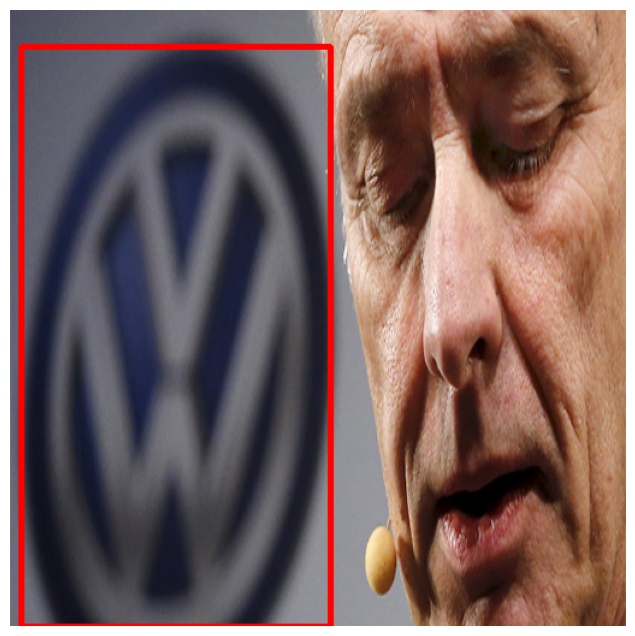

In [ ]:
image = cv2.imread(f'drive/MyDrive/VISION/voc_format_open_set/volkswagen/img000498_107.jpg', cv2.IMREAD_COLOR)  #reading an image
#image = cv2.imread(f'drive/MyDrive/VISION/voc_format_open_set/volkswagen/img000199_107.jpg', cv2.IMREAD_COLOR)
#image = cv2.imread(f'drive/MyDrive/VISION/voc_format_open_set/aral/img000084_16.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)    #changing color space BGR --> RGB
image /= 255.0

print(type(image))
print(image.shape)

bboxes = [[11,18,343,303]]

labels = torch.ones((len(bboxes),), dtype=torch.int64)

im, b = transform_manual(image, bboxes, 512)

print(im.shape[:2])
print(b)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

cv2.rectangle(im,
                  (int(b[0][0]), int(b[0][1])),
                  (int(b[0][2]), int(b[0][3])),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(im)

#Create Dataset and loader

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

base_path = 'drive/MyDrive/VISION/faster r-cnn'

train_path =  'drive/MyDrive/VISION/faster r-cnn/data_train.txt' # Training data (annotation file)
test_path =  'drive/MyDrive/VISION/faster r-cnn/data_test.txt' # Test data (annotation file)

train_dataset = LogoDataset(train_df)
test_dataset = LogoDataset(test_df)


train_data_loader = DataLoader(
    train_dataset,
    batch_size= 9,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Load Faster R-CNN Model

In [20]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 94.5MB/s]


Setting number of classes = 2:         *0 for background, 1 for Logo*

In [21]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#Train

At first we load the weights saved from a previous training (if it is not the first train). Then we define the hyperparameters of the model and an optimizer (SGD). We select the number of epochs and start training.
At the end of each epoch we save the logs of the model, so that it can be reused as inizialization for the next epoch.

In [ ]:
#Hyperparameters
model.load_state_dict(torch.load('/content/drive/MyDrive/VISION/faster r-cnn/model/fasterrcnn_resnet50_fpn_1.pth',map_location=torch.device('cpu')))
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
num_epochs = 4


logger = []
for epoch in range(num_epochs):
# train for one epoch, printing every 10 iterations
    l = train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    logger.append(l)
    # update the learning rate
    lr_scheduler.step()
    torch.save(model.state_dict(), '/content/drive/MyDrive/VISION/faster r-cnn/model/fasterrcnn_resnet50_fpn_1.pth')
    # evaluate on the test dataset
    evaluate(model, test_data_loader, device=device)

print("That's it!")

Epoch: [0]  [  0/631]  eta: 4:18:00  lr: 0.000026  loss: 0.1374 (0.1374)  loss_classifier: 0.0574 (0.0574)  loss_box_reg: 0.0491 (0.0491)  loss_objectness: 0.0240 (0.0240)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 24.5338  data: 15.2665  max mem: 7712
Epoch: [0]  [ 10/631]  eta: 1:18:21  lr: 0.000184  loss: 0.1732 (0.1943)  loss_classifier: 0.0671 (0.0720)  loss_box_reg: 0.0731 (0.0722)  loss_objectness: 0.0240 (0.0261)  loss_rpn_box_reg: 0.0118 (0.0241)  time: 7.5701  data: 5.1437  max mem: 7872
Epoch: [0]  [ 20/631]  eta: 1:05:12  lr: 0.000343  loss: 0.1732 (0.2070)  loss_classifier: 0.0666 (0.0706)  loss_box_reg: 0.0731 (0.0783)  loss_objectness: 0.0217 (0.0279)  loss_rpn_box_reg: 0.0180 (0.0302)  time: 5.4967  data: 3.7289  max mem: 7872
Epoch: [0]  [ 30/631]  eta: 0:57:10  lr: 0.000502  loss: 0.1639 (0.8445)  loss_classifier: 0.0586 (0.0676)  loss_box_reg: 0.0688 (0.0759)  loss_objectness: 0.0221 (0.0476)  loss_rpn_box_reg: 0.0238 (0.6535)  time: 4.6846  data: 2.8762  max mem: 787

In order to have more readable results let's validate one last time at the end of the training procedure

In [22]:
model.load_state_dict(torch.load('/content/drive/MyDrive/VISION/faster r-cnn/model/fasterrcnn_resnet50_fpn_1.pth',map_location=torch.device('cpu')))
model.to(device)
evaluate(model, test_data_loader, device=device)

KeyboardInterrupt: ignored

Now we want to print some images that show how good does our model perform

In [ ]:
#load the model from which we want to show images
model.load_state_dict(torch.load('/content/drive/MyDrive/VISION/faster r-cnn/model/fasterrcnn_resnet50_fpn_1.pth',map_location=torch.device('cpu')))
model.to(device)
model.eval()
images, targets = next(iter(test_data_loader))
images = list(image.to(device) for image in images)
outputs = model(images)

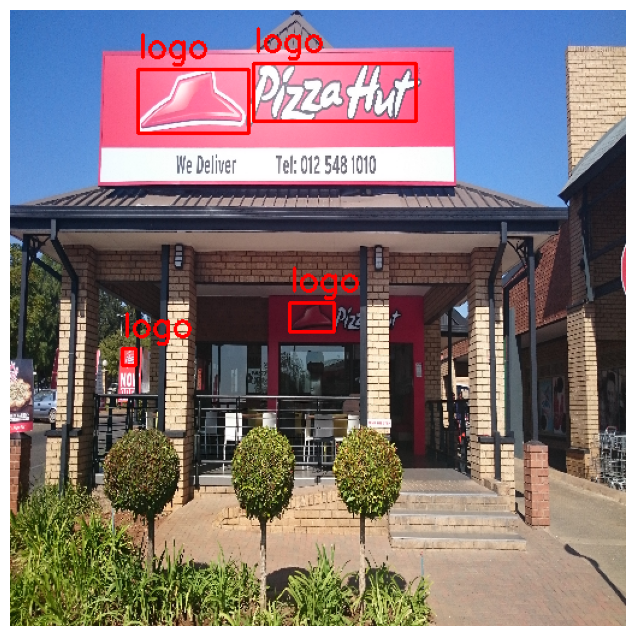

In [ ]:
#choose which of the 8 images that we are considering prom the iterator on the test set we want to display
i = 1
detection_threshold = 0.7
sample = images[i].permute(1,2,0).cpu().numpy()
boxes = outputs[i]['boxes'].data.cpu().numpy()
scores = outputs[i]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    cv2.putText(sample, '', (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample)
